# Movie reviews

This notebook takes you though a complete iteration of Machine Learning Assignment 1 - Movie reviews. The assignment details (including links to download the data) can be found [here](https://docs.google.com/document/d/1WGYw99e5q6j5V0Zrf2HveagU6URt_kVvdR8B9HYQ99E/edit?usp=sharing). 

## import libraries we will use:

In [30]:
# all imports and magic commands
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# from my_measures import BinaryClassificationPerformance
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from scipy.sparse import csr_matrix, hstack
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
%matplotlib inline

## Local BinaryClassificationPerformance()

In [31]:
# my_measures
class BinaryClassificationPerformance():
    '''Performance measures to evaluate the fit of a binary classification model, v1.02'''
    
    def __init__(self, predictions, labels, desc, probabilities=None):
        '''Initialize attributes: predictions-vector of predicted values for Y, labels-vector of labels for Y'''
        '''probabilities-optional, probability that Y is equal to True'''
        self.probabilities = probabilities
        self.performance_df = pd.concat([pd.DataFrame(predictions), pd.DataFrame(labels).reset_index(drop=True)], axis=1, ignore_index=True)
        self.performance_df.columns = ['preds', 'labls']
        self.desc = desc
        self.performance_measures = {}
        self.image_indices = {}
  
    def compute_measures(self):
        '''Compute performance measures defined by Flach p. 57'''
        self.performance_measures['Pos'] = self.performance_df['labls'].sum()
        self.performance_measures['Neg'] = self.performance_df['labls'].shape[0] - self.performance_df['labls'].sum()
        self.performance_measures['TP'] = ((self.performance_df['preds'] == True) & (self.performance_df['labls'] == True)).sum()
        self.performance_measures['TN'] = ((self.performance_df['preds'] == False) & (self.performance_df['labls'] == False)).sum()
        self.performance_measures['FP'] = ((self.performance_df['preds'] == True) & (self.performance_df['labls'] == False)).sum()
        self.performance_measures['FN'] = ((self.performance_df['preds'] == False) & (self.performance_df['labls'] == True)).sum()
        self.performance_measures['Accuracy'] = (self.performance_measures['TP'] + self.performance_measures['TN']) / (self.performance_measures['Pos'] + self.performance_measures['Neg'])
        self.performance_measures['Precision'] = self.performance_measures['TP'] / (self.performance_measures['TP'] + self.performance_measures['FP'])
        self.performance_measures['Recall'] = self.performance_measures['TP'] / self.performance_measures['Pos']
        self.performance_measures['desc'] = self.desc

    def img_indices(self):
        '''Get the indices of true and false positives to be able to locate the corresponding images in a list of image names'''
        self.performance_df['tp_ind'] = ((self.performance_df['preds'] == True) & (self.performance_df['labls'] == True))
        self.performance_df['fp_ind'] = ((self.performance_df['preds'] == True) & (self.performance_df['labls'] == False))
        self.image_indices['TP_indices'] = np.where(self.performance_df['tp_ind']==True)[0].tolist()
        self.image_indices['FP_indices'] = np.where(self.performance_df['fp_ind']==True)[0].tolist()

### IMPORTANT!!! Make sure you are using `BinaryClassificationPerformance` v1.02

In [35]:
help(BinaryClassificationPerformance)

Help on class BinaryClassificationPerformance in module __main__:

class BinaryClassificationPerformance(builtins.object)
 |  BinaryClassificationPerformance(predictions, labels, desc, probabilities=None)
 |  
 |  Performance measures to evaluate the fit of a binary classification model, v1.02
 |  
 |  Methods defined here:
 |  
 |  __init__(self, predictions, labels, desc, probabilities=None)
 |      Initialize attributes: predictions-vector of predicted values for Y, labels-vector of labels for Y
 |  
 |  compute_measures(self)
 |      Compute performance measures defined by Flach p. 57
 |  
 |  img_indices(self)
 |      Get the indices of true and false positives to be able to locate the corresponding images in a list of image names
 |  
 |  ----------------------------------------------------------------------
 |  Data descriptors defined here:
 |  
 |  __dict__
 |      dictionary for instance variables (if defined)
 |  
 |  __weakref__
 |      list of weak references to the object

# Function for feature building and extraction on natural language data

In [33]:
# function that takes raw data and completes all preprocessing required before model fits
def process_raw_data(fn, my_random_seed, test=False):
    # read and summarize data
    movie_data = pd.read_csv(fn, sep='\t')
    print("movie_data is:", type(movie_data))
    print("movie_data has", movie_data.shape[0], "rows and", movie_data.shape[1], "columns", "\n")
    print("the data types for each of the columns in movie_data:")
    print(movie_data.dtypes, "\n")
    print("the first 10 rows in movie_data:")
    print(movie_data.head(5))
    if (not test):
        print("The rate of 'good' movie reviews in the dataset: ")
        print(movie_data['sentiment'].mean())

    # vectorize Bag of Words from review text; as sparse matrix
    if (not test): # fit_transform()
        hv = HashingVectorizer(n_features=2 ** 17, alternate_sign=False)
        X_hv = hv.fit_transform(movie_data.review)
        fitted_transformations.append(hv)
        print("Shape of HashingVectorizer X:")
        print(X_hv.shape)
    else: # transform() 
        X_hv = fitted_transformations[0].transform(movie_data.review)
        print("Shape of HashingVectorizer X:")
        print(X_hv.shape)
    
    # http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfTransformer.html
    if (not test):
        transformer = TfidfTransformer()
        X_tfidf = transformer.fit_transform(X_hv)
        fitted_transformations.append(transformer)
    else:
        X_tfidf = fitted_transformations[1].transform(X_hv)
    
    # create additional quantitative features
    # features from Amazon.csv to add to feature set
    movie_data['word_count'] = movie_data['review'].str.split(' ').str.len()
    movie_data['punc_count'] = movie_data['review'].str.count("\.")

    X_quant_features = movie_data[["word_count", "punc_count"]]
    print("Look at a few rows of the new quantitative features: ")
    print(X_quant_features.head(10))
    
    # Combine all quantitative features into a single sparse matrix
    X_quant_features_csr = csr_matrix(X_quant_features)
    X_combined = hstack([X_tfidf, X_quant_features_csr])
    X_matrix = csr_matrix(X_combined) # convert to sparse matrix
    print("Size of combined bag of words and new quantitative variables matrix:")
    print(X_matrix.shape)
    
    # Create `X`, scaled matrix of features
    # feature scaling
    if (not test):
        sc = StandardScaler(with_mean=False)
        X = sc.fit_transform(X_matrix)
        fitted_transformations.append(sc)
        print(X.shape)
        y = movie_data['sentiment']
    else:
        X = fitted_transformations[2].transform(X_matrix)
        print(X.shape)
    
    # Create Training and Test Sets
    # enter an integer for the random_state parameter; any integer will work
    if (test):
        X_submission_test = X
        print("Shape of X_test for submission:")
        print(X_submission_test.shape)
        print('SUCCESS!')
        return(movie_data, X_submission_test)
    else: 
        X_train, X_test, y_train, y_test, X_raw_train, X_raw_test = train_test_split(X, y, movie_data, test_size=0.2, random_state=my_random_seed)
        print("Shape of X_train and X_test:")
        print(X_train.shape)
        print(X_test.shape)
        print("Shape of y_train and y_test:")
        print(y_train.shape)
        print(y_test.shape)
        print("Shape of X_raw_train and X_raw_test:")
        print(X_raw_train.shape)
        print(X_raw_test.shape)
        print('SUCCESS!')
        return(X_train, X_test, y_train, y_test, X_raw_train, X_raw_test)

# Create training and test sets from function

In [4]:
# create an empty list to store any use of fit_transform() to transform() later
# it is a global list to store model and feature extraction fits
fitted_transformations = []

# CHANGE FILE PATH and my_random_seed number (any integer other than 74 will do): 
X_train, X_test, y_train, y_test, X_raw_train, X_raw_test = process_raw_data(fn='../week04/final_data/moviereviews_train.tsv', my_random_seed=74)

print("Number of fits stored in `fitted_transformations` list: ")
print(len(fitted_transformations))

movie_data is: <class 'pandas.core.frame.DataFrame'>
movie_data has 25000 rows and 3 columns 

the data types for each of the columns in movie_data:
id           object
sentiment     int64
review       object
dtype: object 

the first 10 rows in movie_data:
       id  sentiment                                             review
0  5814_8          1  With all this stuff going down at the moment w...
1  2381_9          1  \The Classic War of the Worlds\" by Timothy Hi...
2  7759_3          0  The film starts with a manager (Nicholas Bell)...
3  3630_4          0  It must be assumed that those who praised this...
4  9495_8          1  Superbly trashy and wondrously unpretentious 8...
The rate of 'good' movie reviews in the dataset: 
0.5
Shape of HashingVectorizer X:
(25000, 131072)
Look at a few rows of the new quantitative features: 
   word_count  punc_count
0         433          20
1         158          16
2         378          20
3         379           8
4         367           9


# Fit (and tune) Various Models

### MODEL: ordinary least squares

In [5]:
from sklearn import linear_model
ols = linear_model.SGDClassifier(loss="squared_loss")
ols.fit(X_train, y_train)

ols_performance_train = BinaryClassificationPerformance(ols.predict(X_train), y_train, 'ols_train')
ols_performance_train.compute_measures()
print(ols_performance_train.performance_measures)

{'Pos': 10033, 'Neg': 9967, 'TP': 4362, 'TN': 5867, 'FP': 4100, 'FN': 5671, 'Accuracy': 0.51145, 'Precision': 0.5154809737650674, 'Recall': 0.43476527459384035, 'desc': 'ols_train'}


### MODEL: SVM, linear

In [6]:
from sklearn import linear_model
svm = linear_model.SGDClassifier()
svm.fit(X_train, y_train)

svm_performance_train = BinaryClassificationPerformance(svm.predict(X_train), y_train, 'svm_train')
svm_performance_train.compute_measures()
print(svm_performance_train.performance_measures)

{'Pos': 10033, 'Neg': 9967, 'TP': 10033, 'TN': 9967, 'FP': 0, 'FN': 0, 'Accuracy': 1.0, 'Precision': 1.0, 'Recall': 1.0, 'desc': 'svm_train'}


### MODEL: logistic regression

In [7]:
from sklearn import linear_model
lgs = linear_model.SGDClassifier(loss='log')
lgs.fit(X_train, y_train)

lgs_performance_train = BinaryClassificationPerformance(lgs.predict(X_train), y_train, 'lgs_train')
lgs_performance_train.compute_measures()
print(lgs_performance_train.performance_measures)

{'Pos': 10033, 'Neg': 9967, 'TP': 10033, 'TN': 9967, 'FP': 0, 'FN': 0, 'Accuracy': 1.0, 'Precision': 1.0, 'Recall': 1.0, 'desc': 'lgs_train'}


### MODEL: Naive Bayes

In [8]:
from sklearn.naive_bayes import MultinomialNB
nbs = MultinomialNB()
nbs.fit(X_train, y_train)

nbs_performance_train = BinaryClassificationPerformance(nbs.predict(X_train), y_train, 'nbs_train')
nbs_performance_train.compute_measures()
print(nbs_performance_train.performance_measures)

{'Pos': 10033, 'Neg': 9967, 'TP': 9633, 'TN': 9811, 'FP': 156, 'FN': 400, 'Accuracy': 0.9722, 'Precision': 0.9840637450199203, 'Recall': 0.9601315658327519, 'desc': 'nbs_train'}


### MODEL: Perceptron

In [9]:
from sklearn import linear_model
prc = linear_model.SGDClassifier(loss='perceptron')
prc.fit(X_train, y_train)

prc_performance_train = BinaryClassificationPerformance(prc.predict(X_train), y_train, 'prc_train')
prc_performance_train.compute_measures()
print(prc_performance_train.performance_measures)

{'Pos': 10033, 'Neg': 9967, 'TP': 10033, 'TN': 9967, 'FP': 0, 'FN': 0, 'Accuracy': 1.0, 'Precision': 1.0, 'Recall': 1.0, 'desc': 'prc_train'}


### MODEL: Ridge Regression Classifier

In [10]:
from sklearn import linear_model
rdg = linear_model.RidgeClassifier()
rdg.fit(X_train, y_train)

rdg_performance_train = BinaryClassificationPerformance(rdg.predict(X_train), y_train, 'rdg_train')
rdg_performance_train.compute_measures()
print(rdg_performance_train.performance_measures)

{'Pos': 10033, 'Neg': 9967, 'TP': 10033, 'TN': 9967, 'FP': 0, 'FN': 0, 'Accuracy': 1.0, 'Precision': 1.0, 'Recall': 1.0, 'desc': 'rdg_train'}


### MODEL: Random Forest Classifier

In [11]:
from sklearn.ensemble import RandomForestClassifier
rdf = RandomForestClassifier(max_depth=2, random_state=0)
rdf.fit(X_train, y_train)

rdf_performance_train = BinaryClassificationPerformance(rdf.predict(X_train), y_train, 'rdf_train')
rdf_performance_train.compute_measures()
print(rdf_performance_train.performance_measures)

{'Pos': 10033, 'Neg': 9967, 'TP': 8847, 'TN': 6588, 'FP': 3379, 'FN': 1186, 'Accuracy': 0.77175, 'Precision': 0.7236217896286602, 'Recall': 0.8817900926941095, 'desc': 'rdf_train'}


### ROC plot to compare performance of various models and fits

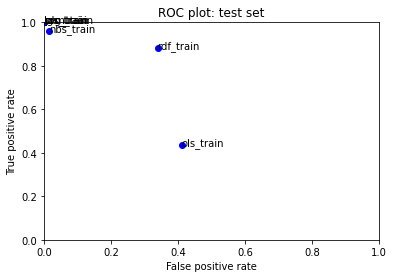

In [12]:
fits = [ols_performance_train, svm_performance_train, lgs_performance_train, nbs_performance_train, prc_performance_train, rdg_performance_train, rdf_performance_train]

for fit in fits:
    plt.plot(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], 'bo')
    plt.text(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], fit.desc)
plt.axis([0, 1, 0, 1])
plt.title('ROC plot: test set')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.show()

### looking at reviews based on their classification

Let's say we decide that Ordinary Least Squares (OLS) Regression is the best model for generalization. Let's take a look at some of the reviews and try to make a (subjective) determination of whether it's generalizing well. 

In [13]:
ols_predictions = ols.predict(X_train)

### let's look at some false positives:

In [14]:
# false positives

print("Examples of false positives:")

import random, time

for i in range(0, len(ols_predictions)):
    if (ols_predictions[i] == 1):
        if (X_raw_train.iloc[i]['sentiment'] == 0):
            if (random.uniform(0, 1) < 0.05): # to print only 5% of the false positives
                print(i)
                print(X_raw_train.iloc[i]['review'])
                print('* * * * * * * * * ')


Examples of false positives:
132
A worn-out plot of a man who takes the rap for a woman in a murder case + the equally worn-out plot of an outsider on the inside who eventually is shut out.<br /><br />With such an outstanding case, one would think the film would rise above its hackneyed origins. But scene after scene drones by with no change in intensity, no character arcs, and inexplicable behavior.<br /><br />The homosexuality theme was completely unnecessary -- or on the other hand, completely unexplored. It seemed to be included only to titillate the viewers. When will Hollywood learn that having gay characters does not automatically make a more compelling picture?<br /><br />A regrettably dreadful movie. When will Lauren Bacall pick a good one? I expected better of her and Kristin Scott Thomas. This one is definitely one to miss.
* * * * * * * * * 
150
Bad acting. Bad writing. This was a poorly written film. It's too bad because it had some potential. It's not even close to Americ

3874
I watched this movie last week sometime and had the biggest laugh i've had in a long while. The plot of the film is pretty dumb and convoluted in a badly crafted way. The only plus to be found anywhere in the film are Corey Savier's impressive abs. Alexandra Paul (i think that's her name) is horrendous as the preacher's wife who has a history of depression. Ted McKenzie is gross and his character's a twit on top of it all. And as if the fact that you think she's having sex with her son isn't enough, they throw in needless sax solos at every opportunity! The end and climax of this film is absolutely abysmal and also laughable. I mean who the hell wants to carry the child of a con who tried to make you think he was your son and that you were having an incestuous relationship with him!
* * * * * * * * * 
3960
Near the beginning of \The Godfather: Part III,\" Michael Corleone's son wants to drop out of law school and become a musician. Michael Corleone does not want this. But his estr

4990
Normally I dont have a problem with gratuitous swearing in films, but this one really annoyed me. All they did was swear. For the whole film. (And, as someone else noted, get cancer) It was boring, rambling and pretentious. I wouldnt If I were you. <br /><br />Its also not that I dont like films which, as most people who like it will claim 'observe life'. I love Eat Drink Man Woman, and all that happens in that is that a load of Taiwanese people lead their lives. But I could relate to them. I have never met anyone who swore as much as the 'actors' in this film, and I used to work on a construction site. So go figure. Having said that William H. Macy made me grin. Once. <br /><br />2/10. Avoid, unless you enjoy tedium.
* * * * * * * * * 
5063
I just saw this Movie on a local TV Station (TV8's \Big Chuck and Little John\" in Cleveland, Ohio) I had never heard of this movie and decided to watch it.<br /><br />I know of no thesaurus that can even come close to aiding me in describing 

7583
Ok, honestly I dont see why everybody thinks this is so great. Its really not. There were two good things that came out of this movie 1. Jack's performance, he was very good I can tip my hat for him. 2. Danny's performance, he was good. No other then that it got pretty stupid. And, what was Stanley Kubrick thinking drafting Shelly as the Wendy? She was so bad. She looked the same every time she got scared. The problem with this movie was the ending. I would have had more respect for it if Kubrick would have ended it differently. And, the over all movie was just stupid. The problem with the movie is that the book was so much better. So dont see the movie read the book and you will be much better off. 3/10.
* * * * * * * * * 
7710
The night of the prom: the most important night to any shallow girl composed almost entirely of plastic. And so the characters kept reminding us every ten minutes when some head-peckingly miniscule event occurred in their miniscule lives.<br /><br />There 

8745
I just loved watching it though and having fun with it's total badness of a film. I saw this film through the helpful sarcasm of Mystery Science Theater 3000 and I have the DVD. If you flip the to the other side of the DVD, they show the actual movie, so I gave it a chance. Seriously, folks this is grilled cheese.<br /><br />The acting, special effects, and plot in general is very cheesy and unrealistic. \Doesn't she need lungs\" said Crow noticing how the head can still talk while it doesn't have a body, and Tom Servo just wistfully remarks \"No, she's got neck juice!\". The ending is just classic and no one can touch this soundtrack with K-Porn! I loved the \"cat fight\" between the two strippers. That \"Meow\" after the fight or scene, whatever, was classic. So, in some ways this was a fun movie. I think for horror fans, you'll probably enjoy it. For a good time, watch the MSTK3 version, you'll get a great laugh.<br /><br />MST3K version: 10/10 The Brain that would die: 1/10"
*

11127
I watched this a few days ago, so details are getting hazy. The film is shot on hand-held cameras, and a lot was made of this at the time it was released originally, since we hadn't had many studio pictures made in this way. I can't help but feel this was more of a gimmick than anything, designed to make the audience think that what we are seeing on the screen hasn't had all the compromises that come with a big budget, and so was more \real\". However what we have here isn't much more than a not-as-good rip off of the first half of Full Metal Jacket, so anyone who has seen that, or any one of the other rip offs there of, will know what to expect.<br /><br />The main problem I had was the stereotyped characters, with the weedy soft kids out of their depth, close harmony singing, Ebonics spouting black dudes, world weary sergeants, bitter and twisted psychos etc etc... all being put into the sorts of situations that would provide the most friction and tension at any given time. May

12678
Now, I flicked onto this just out of curiosity and had to keep watching - in the same way that you watch a car crash...<br /><br />I appreciate the fact it's a spoof, but that should not stop me from criticising the god-awful directing, acting and dialogue. Seriously, this rated as one of the poorest movies I have seen - it looked more like an episode of Tales from the Cryptkeeper, and a poor one at that...<br /><br />Okay - a few criticisms (1) when the doctor had his heart attack in front of the monster (we never see the monster attack him, so we assume its a heart attack), the army then launch shells, rockets, bullets at the monster - which was feet from the doctor - yet the doctor is not touched by any missile and is still alive (2) the army attack from about 100 yards away, and we see a flame-thrower being used - geez, those things have a range of no more than 30 metres! (3) when the monster tries to take the professor, the soldiers run into the classroom and fire into the c

14358
This film is pure, distilled, unadulterated boredom. I knew nothing of it before I entered the dark room, took my seat. I was seduced by the \mysterious and suspenseful\" blurb on the poster I suppose. Also, Lena Headey is nice and unconventionally sexy, and Richard Jenkins is always a reliable guy to have around, so the cast seemed reasonable. It may have been his name above the title that convinced me to go with this instead of whatever else was on. I should've gone to see Valkyrie for the second time instead.<br /><br />The thin plot revolves around Headley's Gina McVey, her boyfriend, her father, her sister and her sister's husband who for some reason are being stalked, in a very louche and unenthusiastic manner, by their evil doppelgangers who emerge from mirrors that mysteriously smash. There could be a great film behind this idea (not exactly an original idea, mind you, but still...) and in fact, if the filmmakers had shorn away all the supporting cast and simply stuck to 

15680
All these reviewers are spot on. I've seen many bad films over the years, believe me, and this beats the lot!<br /><br />This is not just a \so bad it's good\" exploiter waste of time, but a genuine, hilarious, movie atrocity.<br /><br />CHECK OUT the white furry monster type thing!<br /><br />WET YOURSELF LAUGHING at Thom Christopher's \"spell-weaving\" acting!<br /><br />GAPE IN SHEER A**E-CLENCHING DISBELIEF! at the threadbare sets!<br /><br />This is one of those \"European co-productions\". No wonder we have so many wars. I swear, some of the people taking part in 'Wizards of the Lost Kingdom' aren't actually aware they are appearing in a film!<br /><br />FACT! I originally watched this movie on HTV Wales late one night while suffering from concussion and sleep deprivation. I had to track down a copy several weeks later to make sure it was really this awful. It is. Worse even than Lee Majors in The Norseman, more laughable than all of John Derek's films, this is, truly, the 

17643
I was forced to watch this whole series of films as a young child and I was told they were REAL! Talk about child abuse. I would have been less frightened of Dracula or Frankenstein. This series is only good for people who believe in this ridiculousness and who want to indoctrinate their children into believing the same. Besides the obvious issues associated with brainwashing and indoctrination, there's also the bad acting, bad writing, and BAD \special effects\". They are just all around terrible, terrible movies. Yes, believable (and horrifying) to a kid, but I can't imagine a grown-up buying into this shlock. Although, I must say, that I would be interested in seeing them today, as an adult. They might have a certain midnight/cult movie feel to them."
* * * * * * * * * 
17654
Murders are occurring in a Texas desert town. Who is responsible? Slight novelties of mystery and racial tensions (the latter really doesn't fit), but otherwise strictly for slasher fans, who will appreci

19219
I disliked Frosty returns and this one. Both of the films are absurd with poorly written characters and bad voices. The voices could have been done but Frosty returns was worst than this because of the unalike snowman they drew. Frosty's winterwonder land was great and so was the original heartwarming Drama. The only good thing about this film was Frosty the snowman was alike of the classic 60s and a funny line like when they were talking about things that are not real and then Frosty walks by the window humming, whistling whatever he was doing but everything else was badly written and badly animated and I barely got the plot. I saw the DVD cover at the library about 2 or 3 years ago and the art looked crappy so I didn't pick it up until this year because the pictures on the back looked a little touching but I played this film. It was a hassle poorly art characters just like the DVD and it was just terrible about what's going on. I watched this at night and found it dull that I f

---

# <span style="color:red">WARNING: Don't look at test set performance too much!</span>

---

The following cells show performance on your test set. Do not look at this too often! 

# Look at performance on the test set

### MODEL: ordinary least squares

In [15]:
ols_performance_test = BinaryClassificationPerformance(ols.predict(X_test), y_test, 'ols_test')
ols_performance_test.compute_measures()
print(ols_performance_test.performance_measures)

{'Pos': 2467, 'Neg': 2533, 'TP': 1032, 'TN': 1599, 'FP': 934, 'FN': 1435, 'Accuracy': 0.5262, 'Precision': 0.5249237029501526, 'Recall': 0.418321848398865, 'desc': 'ols_test'}


### MODEL: SVM, linear

In [16]:
svm_performance_test = BinaryClassificationPerformance(svm.predict(X_test), y_test, 'svm_test')
svm_performance_test.compute_measures()
print(svm_performance_test.performance_measures)

{'Pos': 2467, 'Neg': 2533, 'TP': 2063, 'TN': 2095, 'FP': 438, 'FN': 404, 'Accuracy': 0.8316, 'Precision': 0.8248700519792083, 'Recall': 0.8362383461694366, 'desc': 'svm_test'}


### MODEL: logistic regression

In [17]:
lgs_performance_test = BinaryClassificationPerformance(lgs.predict(X_test), y_test, 'lgs_test')
lgs_performance_test.compute_measures()
print(lgs_performance_test.performance_measures)

{'Pos': 2467, 'Neg': 2533, 'TP': 2049, 'TN': 2102, 'FP': 431, 'FN': 418, 'Accuracy': 0.8302, 'Precision': 0.8262096774193548, 'Recall': 0.8305634373733279, 'desc': 'lgs_test'}


### MODEL: Naive Bayes

In [18]:
nbs_performance_test = BinaryClassificationPerformance(nbs.predict(X_test), y_test, 'nbs_test')
nbs_performance_test.compute_measures()
print(nbs_performance_test.performance_measures)

{'Pos': 2467, 'Neg': 2533, 'TP': 1768, 'TN': 1907, 'FP': 626, 'FN': 699, 'Accuracy': 0.735, 'Precision': 0.7385129490392648, 'Recall': 0.7166599108228617, 'desc': 'nbs_test'}


### MODEL: Perceptron

In [19]:
prc_performance_test = BinaryClassificationPerformance(prc.predict(X_test), y_test, 'prc_test')
prc_performance_test.compute_measures()
print(prc_performance_test.performance_measures)

{'Pos': 2467, 'Neg': 2533, 'TP': 2076, 'TN': 2104, 'FP': 429, 'FN': 391, 'Accuracy': 0.836, 'Precision': 0.8287425149700599, 'Recall': 0.8415079043372518, 'desc': 'prc_test'}


### MODEL: Ridge Regression Classifier

In [20]:
rdg_performance_test = BinaryClassificationPerformance(rdg.predict(X_test), y_test, 'rdg_test')
rdg_performance_test.compute_measures()
print(rdg_performance_test.performance_measures)

{'Pos': 2467, 'Neg': 2533, 'TP': 2029, 'TN': 2011, 'FP': 522, 'FN': 438, 'Accuracy': 0.808, 'Precision': 0.7953743629949039, 'Recall': 0.8224564248074584, 'desc': 'rdg_test'}


### MODEL: Random Forest Classifier

In [21]:
rdf_performance_test = BinaryClassificationPerformance(rdf.predict(X_test), y_test, 'rdf_test')
rdf_performance_test.compute_measures()
print(rdf_performance_test.performance_measures)

{'Pos': 2467, 'Neg': 2533, 'TP': 2152, 'TN': 1677, 'FP': 856, 'FN': 315, 'Accuracy': 0.7658, 'Precision': 0.7154255319148937, 'Recall': 0.8723145520875557, 'desc': 'rdf_test'}


### ROC plot to compare performance of various models and fits

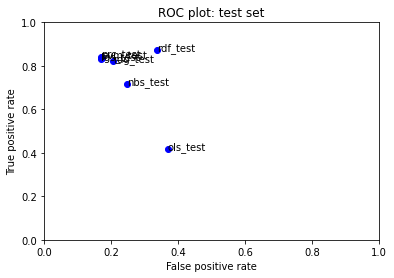

In [22]:
fits = [ols_performance_test, svm_performance_test, lgs_performance_test, nbs_performance_test, prc_performance_test, rdg_performance_test, rdf_performance_test]

for fit in fits:
    plt.plot(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], 'bo')
    plt.text(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], fit.desc)
plt.axis([0, 1, 0, 1])
plt.title('ROC plot: test set')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.show()

---

# <span style="color:red">SUBMISSION</span>

---

In [24]:
# read in test data for submission
# CHANGE FILE PATH and my_random_seed number (any integer other than 74 will do): 
raw_data, X_test_submission = process_raw_data(fn='../week04/final_data/moviereviews_test.tsv', my_random_seed=74, test=True)
print("Number of rows in the submission test set (should be 25,000): ")

movie_data is: <class 'pandas.core.frame.DataFrame'>
movie_data has 25000 rows and 2 columns 

the data types for each of the columns in movie_data:
id        object
review    object
dtype: object 

the first 10 rows in movie_data:
         id                                             review
0  12311_10  Naturally in a film who's main themes are of m...
1    8348_2  This movie is a disaster within a disaster fil...
2    5828_4  All in all, this is a movie for kids. We saw i...
3    7186_2  Afraid of the Dark left me with the impression...
4   12128_7  A very accurate depiction of small time mob li...
Shape of HashingVectorizer X:
(25000, 131072)
Look at a few rows of the new quantitative features: 
   word_count  punc_count
0         131           5
1         169          15
2         176          18
3         112           5
4         133           8
5         331          20
6         121          18
7         230          22
8          59           3
9         224          14
Size

---

Choose a <span style="color:red">*single*</span> model for your submission. In this code, I am choosing the Ordinary Least Squares model fit, which is in the `ols` object. But you should choose the model that is performing the best for you! 

In [25]:
# store the id from the raw data
my_submission = pd.DataFrame(raw_data["id"])
# concatenate predictions to the id
my_submission["prediction"] = ols.predict(X_test_submission)
# look at the proportion of positive predictions
print(my_submission['prediction'].mean())

0.40176


In [26]:
raw_data.head()

,id,review,word_count,punc_count
0,12311_10,Naturally in a film who's main themes are of m...,131,5
1,8348_2,This movie is a disaster within a disaster fil...,169,15
2,5828_4,"All in all, this is a movie for kids. We saw i...",176,18
3,7186_2,Afraid of the Dark left me with the impression...,112,5
4,12128_7,A very accurate depiction of small time mob li...,133,8


In [27]:
my_submission.head()

,id,prediction
0,12311_10,0
1,8348_2,0
2,5828_4,0
3,7186_2,0
4,12128_7,1


In [28]:
my_submission.shape

(25000, 2)

In [29]:
# export submission file as pdf
# CHANGE FILE PATH: 
my_submission.to_csv('/home/ec2-user/data/moviereviews_submission.csv', index=False)

FileNotFoundError: [Errno 2] No such file or directory: '/home/ec2-user/data/moviereviews_submission.csv'

# Submit to Canvas: 1) the CSV file that was written in the previous cell and 2) the url to the repository (GitHub or other) that contains your code and documentation